## Transfer Learning on Cats-Dogs Classification - Feature Extraction - Solution

#### Features are extracted from a MobileNet-V2 model pre-trained on ImageNet data, then passed through a new classification head to classify cats vs. dogs.
Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### CIML Summer Institute
UC San Diego

-----

### Setup

In [1]:
# Set logging level.  Suppress all logs except errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import datetime

In [3]:
print("Tensorflow version:",tf.__version__)
!python --version

Tensorflow version: 2.15.1
Python 3.10.12


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!nvidia-smi

Tue Jun 25 11:48:24 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   31C    P0    40W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Set random generator seed
seed = 1234

# Set Python seed, NumPy seed, and TensorFlow seed
tf.keras.utils.set_random_seed(seed)

# Potential randomness from CUDNN
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image location and dimensions

In [8]:
import os 

from os.path import expanduser
HOME = expanduser("~")
data_path = HOME + '/data/catsVsDogs'
print (data_path)

# Location of images
train_data_dir = data_path + '/train'
val_data_dir   = data_path + '/val'
test_data_dir  = data_path + '/test'

print ('Train path:' + train_data_dir)
print ('Validation path:' + val_data_dir)
print ('Test path:' + test_data_dir)

/home/train109/data/catsVsDogs
Train path:/home/train109/data/catsVsDogs/train
Validation path:/home/train109/data/catsVsDogs/val
Test path:/home/train109/data/catsVsDogs/test


In [9]:
# Image dimensions
img_width, img_height = 224,224 
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

### Prepare data

In [10]:
# Batch size
BATCH_SIZE = 16

# Data augmentation setup
rescale = tf.keras.applications.mobilenet_v2.preprocess_input
train_datagen      = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = rescale)
validation_datagen = ImageDataGenerator(preprocessing_function = rescale)
test_datagen       = ImageDataGenerator(preprocessing_function = rescale)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE, 
    class_mode = 'binary', 
    shuffle = True, 
    seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = validation_datagen.flow_from_directory(
    val_data_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = False, 
    seed = seed)

# Set up generator to generate batched of test data for model
test_generator = test_datagen.flow_from_directory(
    test_data_dir, 
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    shuffle = False, 
    seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load pre-trained model

In [11]:
#Load pre-trained model's Imagenet weights not including the fully connected layers
base_model = applications.MobileNetV2(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = IMG_SHAPE)

# Freeze all weights of pre-trained model
base_model.trainable = False

# Needed to keep BatchNormalization layers in inference mode for pre-trained model. 
# See https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization 
base_model.training  = False

# Look at pre-trained model's architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

### Create top model

In [12]:
img_inputs = tf.keras.Input(shape=(img_width, img_height, 3))
base_outputs = base_model(img_inputs)

GlobalAveragePooler2D = GlobalAveragePooling2D()
GlobalAveragePooler2D_outputs = GlobalAveragePooler2D(base_outputs)

Dropper = Dropout(0.2)
DroppedOut_outputs = Dropper(GlobalAveragePooler2D_outputs)

DenseLayer = Dense(1, activation='sigmoid')
outputs = DenseLayer(DroppedOut_outputs)

model = tf.keras.Model(inputs=img_inputs, outputs=outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 

### Train top model

In [14]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss= losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [15]:
%%time

# Train top model for 5 epochs
EPOCHS = 5

train_history = model.fit(
    train_generator,
    validation_data=validation_generator, 
    epochs=EPOCHS)

Epoch 1/5


I0000 00:00:1719341314.561205  724116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 27s 149ms/step - loss: 0.6385 - accuracy: 0.6400 - val_loss: 0.3821 - val_accuracy: 0.9100
Epoch 2/5
125/125 [==============================] - 18s 142ms/step - loss: 0.3592 - accuracy: 0.9005 - val_loss: 0.2333 - val_accuracy: 0.9625
Epoch 3/5
125/125 [==============================] - 18s 142ms/step - loss: 0.2472 - accuracy: 0.9390 - val_loss: 0.1687 - val_accuracy: 0.9725
Epoch 4/5
125/125 [==============================] - 18s 142ms/step - loss: 0.1874 - accuracy: 0.9530 - val_loss: 0.1346 - val_accuracy: 0.9725
Epoch 5/5
125/125 [==============================] - 18s 143ms/step - loss: 0.1481 - accuracy: 0.9665 - val_loss: 0.1148 - val_accuracy: 0.9750
CPU times: user 1min 30s, sys: 1.65 s, total: 1min 32s
Wall time: 1min 38s


In [16]:
# Save weights from trained model
model.save("models/features_model")

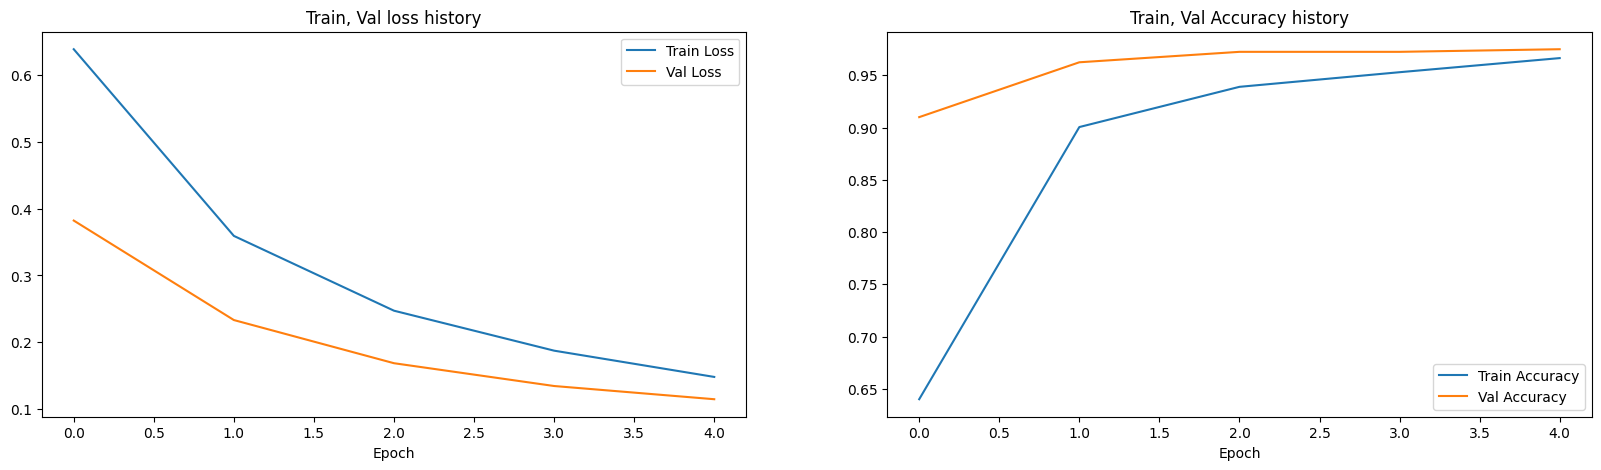

In [17]:
# Plot train and validation history
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluation and Inference

In [18]:
# Get train data accuracy
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

# Get test data accuracy
_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 17s 136ms/step - loss: 0.1329 - accuracy: 0.9725
Train data accuracy: 0.9725000262260437
25/25 [==============================] - 1s 32ms/step - loss: 0.1142 - accuracy: 0.9700
Test data accuracy: 0.9700000286102295


In [19]:
# Get predicted value and the ground truth value of test data
pred = (model.predict(test_generator) > 0.5).astype("int32")
true = test_generator.classes

25/25 [==============================] - 1s 30ms/step


In [20]:
# Get evaluation metrics for test data
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs'], digits=4))

              precision    recall  f1-score   support

        cats     0.9653    0.9750    0.9701       200
        dogs     0.9747    0.9650    0.9698       200

    accuracy                         0.9700       400
   macro avg     0.9700    0.9700    0.9700       400
weighted avg     0.9700    0.9700    0.9700       400



### Perform inference on test images

In [21]:
def image_loader(img_file):
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    img = (img_to_array(img)/127.5)-1.0
    img = np.expand_dims(img, axis = 0) #model input is (1,width,height,channels)
    return img

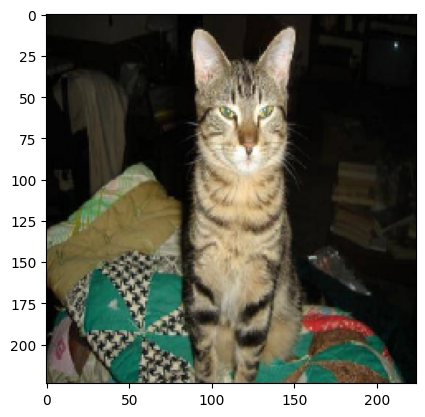

1/1 [==============================] - 1s 640ms/step
[[0.08683]]


In [22]:
test_image = data_path + '/test/cats/cat.1070.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

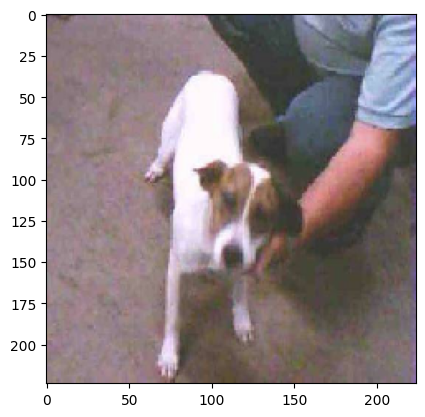

1/1 [==============================] - 0s 25ms/step
[[0.9728]]


In [23]:
test_image = data_path + '/test/dogs/dog.1233.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

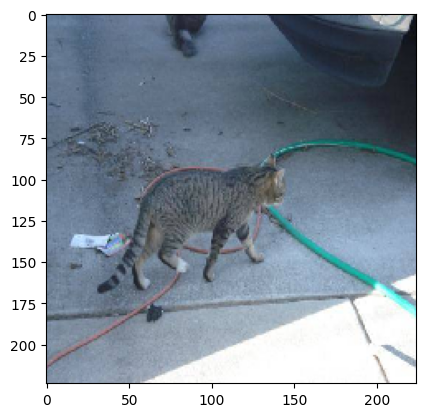

1/1 [==============================] - 0s 24ms/step
[[0.31006]]


In [24]:
test_image = data_path + '/test/cats/cat.1080.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

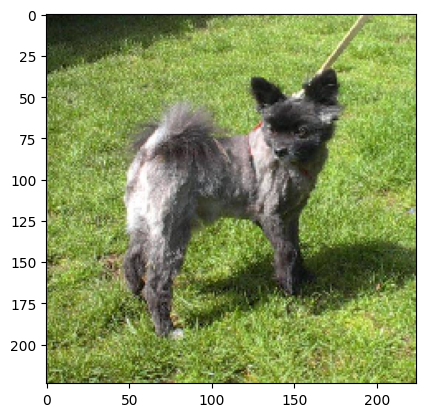

1/1 [==============================] - 0s 24ms/step
[[0.71759]]


In [25]:
test_image = data_path + '/test/dogs/dog.1132.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

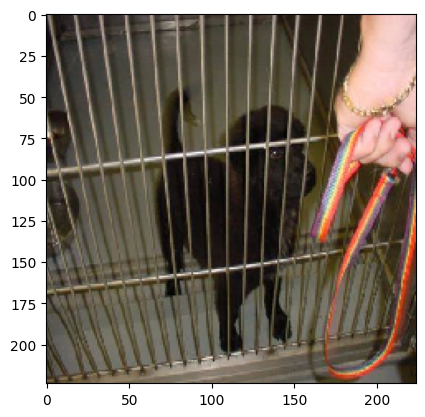

1/1 [==============================] - 0s 23ms/step
[[0.25546]]


In [26]:
test_image = data_path + '/test/dogs/dog.1311.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))